In [ ]:
# Environment setup function
def setup_spark_environment():
    # Install dependencies
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
    !tar xf spark-3.5.4-bin-hadoop3.tgz
    !pip install -q findspark

    # Set environment variables
    import os
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

    # Initialize findspark
    import findspark
    findspark.init()

    # Create Spark session
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

    return spark

# Call setup function
spark = setup_spark_environment()

#Task 2

##Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np

##Preprocess data

In [ ]:
def load_and_preprocess_data(file_path):
    #Read the dataset
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    df = df.withColumn("Date", col("Date").cast("date")).orderBy("Date")

    #Create lag features
    windowSpec = Window.orderBy("Date")
    for i in range(1, 11):
        df = df.withColumn(f"lag_{i}", lag("Sell Price", i).over(windowSpec))

    #Drop rows with null values
    df = df.na.drop()
    return df

##Create feature vectors and split data

In [ ]:
def prepare_ml_data(df):
    #Create feature vector using VectorAssembler
    feature_cols = [f"lag_{i}" for i in range(1, 11)]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    #Select columns
    data = df.select("Date", *feature_cols, col("Sell Price").alias("label"))
    vector_data = assembler.transform(data).select("Date", "features", "label")

    #Split the data
    train_data, test_data = vector_data.randomSplit([0.7, 0.3], seed=42)
    return train_data, test_data

##Train and evaluate model

In [ ]:
def train_and_evaluate_model(train_data, test_data):
    lr = LinearRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=10,
        regParam=0.1,
        elasticNetParam=0.5,
        standardization=True,
        tol=1e-12,
        solver="l-bfgs"
    )

    model = lr.fit(train_data)
    summary = model.summary

    #Manually track and log loss if needed
    if len(summary.objectiveHistory) <= 1:
        print("Warning: Model converged in just one iteration, which is unusual.")
        print("Consider adjusting the regularization or solver parameters.")

    #Evaluate the model
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

    #Calculate metrics for both training and test sets
    train_rmse = evaluator.setMetricName("rmse").evaluate(model.transform(train_data))
    test_rmse = evaluator.setMetricName("rmse").evaluate(model.transform(test_data))
    train_mae = evaluator.setMetricName("mae").evaluate(model.transform(train_data))
    test_mae = evaluator.setMetricName("mae").evaluate(model.transform(test_data))
    train_r2 = evaluator.setMetricName("r2").evaluate(model.transform(train_data))
    test_r2 = evaluator.setMetricName("r2").evaluate(model.transform(test_data))

    metrics = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

    return model, summary, metrics

##Visualize

In [ ]:
def create_visualizations(summary, metrics):
    loss_history = summary.objectiveHistory

    #Plotting loss graph
    plt.figure(figsize=(10, 6))
    if len(loss_history) > 1:
        plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo-', linewidth=2)
        plt.title("Training Loss Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)
    else:
        plt.scatter([1], loss_history, color='blue', s=100)
        plt.xlim(0, 2)
        plt.title("Training Loss (Model Converged in One Iteration)")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)

        plt.annotate("Model converged immediately.\nConsider adjusting regularization parameters.",
                    xy=(1, loss_history[0]),
                    xytext=(1.2, loss_history[0]),
                    arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

    #Bar chart for metrics comparison
    metric_names = ['RMSE', 'MAE', 'R²']
    train_values = [metrics['train_rmse'], metrics['train_mae'], metrics['train_r2']]
    test_values = [metrics['test_rmse'], metrics['test_mae'], metrics['test_r2']]

    x = np.arange(len(metric_names))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, train_values, width, label='Training')
    plt.bar(x + width/2, test_values, width, label='Test')
    plt.ylabel('Value')
    plt.title('Model Performance Metrics')
    plt.xticks(x, metric_names)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

##Main

Dataset sample:
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|      Date|Buy Price|Sell Price|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|2009-08-11|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-12|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-13|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-14|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-15|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
only showing top 5 rows

Training set size: 3964
Test set size: 1591
Training RMSE: 0.4431
Test RMSE: 0.3760
Training R²: 0.9992


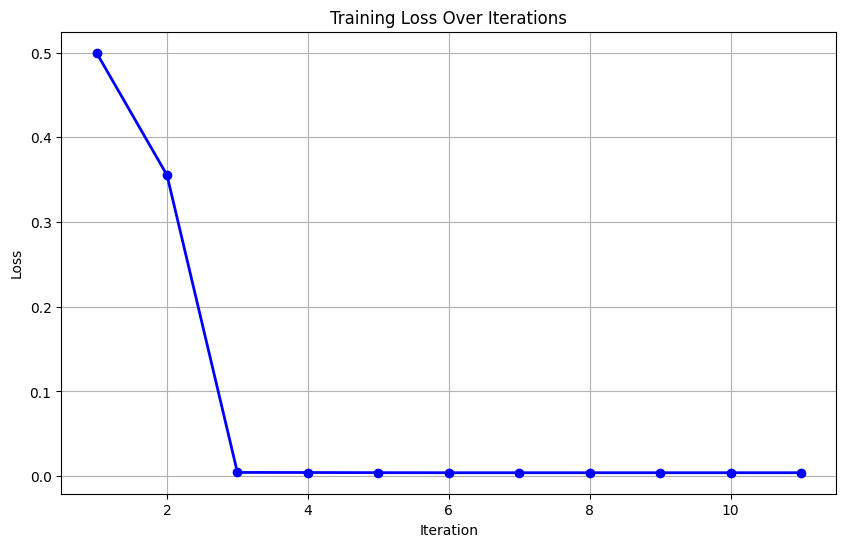

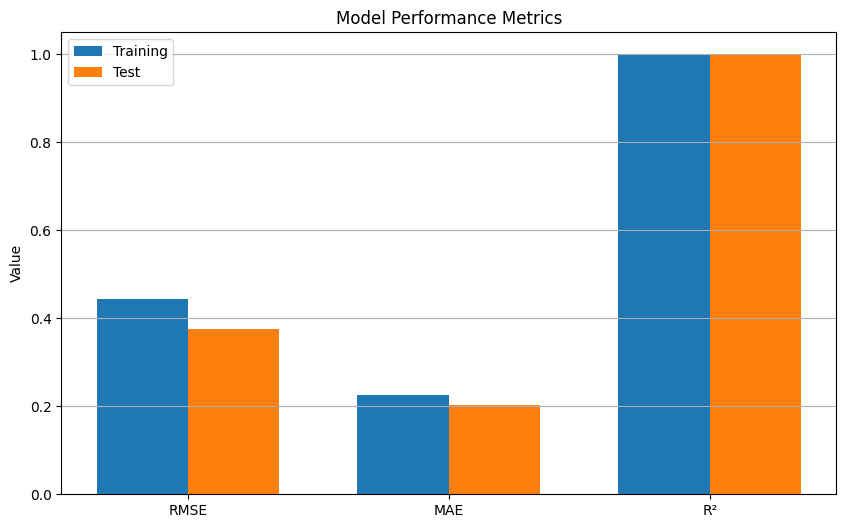

In [ ]:
def main():
    file_path = "gold_prices.csv"
    df = load_and_preprocess_data(file_path)
    print("Dataset sample:")
    df.show(5)

    #Prepare data
    train_data, test_data = prepare_ml_data(df)
    print(f"Training set size: {train_data.count()}")
    print(f"Test set size: {test_data.count()}")

    #Train and evaluate the model
    model, summary, metrics = train_and_evaluate_model(train_data, test_data)

    #Print evaluation metrics
    print(f"Training RMSE: {metrics['train_rmse']:.4f}")
    print(f"Test RMSE: {metrics['test_rmse']:.4f}")
    print(f"Training R²: {metrics['train_r2']:.4f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")

    #Create visualizations
    create_visualizations(summary, metrics)

if __name__ == "__main__":
    main()